# The Mighty USE of NLP -- Universal Sentence Encoder

This notebook illustrates how to access the Universal Sentence Encoder and use it for sentence similarity and sentence classification tasks.

The Universal Sentence Encoder makes getting sentence level embeddings as easy as it has historically been to lookup the embeddings for individual words. The sentence embeddings can then be trivially used to compute sentence level meaning similarity as well as to enable better performance on downstream classification tasks using less supervised training data.

[Link to arxiv paper is here](https://arxiv.org/abs/1803.11175)

## Talk to Books

<img src="images/Talk2Books.png">


[Natural language understanding](https://en.wikipedia.org/wiki/Natural_language_understanding) has evolved substantially in the past few years, in part due to the development of [word vectors](https://www.tensorflow.org/tutorials/word2vec) that enable algorithms to learn about the relationships between words, based on examples of actual language usage. These vector models map semantically similar phrases to nearby points based on equivalence, similarity or relatedness of ideas and language. Last year, we used hierarchical vector models of language to make improvements to [Smart Reply for Gmail](https://research.googleblog.com/2017/05/efficient-smart-reply-now-for-gmail.html). More recently, we’ve been exploring other applications of these methods. 

Today, we are proud to share Semantic Experiences, a website showing two examples of how these new capabilities can drive applications that weren’t possible before. Talk to Books is an entirely new way to explore books by starting at the sentence level, rather than the author or topic level. Semantris is a word association game powered by machine learning, where you type out words associated with a given prompt. We have also published “Universal Sentence Encoder”, or as I call it **USE** which describes the models used for these examples in more detail. Lastly, we’ve provided a [pretrained semantic TensorFlow module](https://tfhub.dev/google/universal-sentence-encoder/1) for the community to experiment with their own sentence and phrase encoding. 

#### Modeling approach
Our approach extends the idea of representing language in a vector space by creating vectors for larger chunks of language such as full sentences and small paragraphs. Since language is composed of hierarchies of concepts, we create the vectors using a hierarchy of modules, each of which considers features that correspond to sequences at different temporal scales. Relatedness, synonymy, antonymy, meronymy, holonymy, and many other types of relationships may all be represented in vector space language models if we train them in the right way and then pose the right “questions”. We describe this method in our paper, [“Efficient Natural Language Response for Smart Reply.”](https://arxiv.org/abs/1705.00652) 

#### Talk to Books

With [Talk to Books](https://books.google.com/talktobooks), we provide an entirely new way to explore books. You make a statement or ask a question, and the tool finds sentences in books that respond, with no dependence on keyword matching. In a sense you are talking to the books, getting responses which can help you determine if you’re interested in reading them or not. 

A bit more on the Pre-trained model
--------------------

The Universal Sentence Encoder encodes text into high dimensional vectors that can be used for text classification, semantic similarity, clustering and other natural language tasks.

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 512 dimensional vector. We apply this model to the STS benchmark for semantic similarity, and the results can be seen in the example notebook made available. To learn more about text embeddings, refer to the TensorFlow Embeddings documentation. Our encoder differs from word level embedding models in that we train on a number of natural language prediction tasks that require modeling the meaning of word sequences rather than just individual words. Details are available in the paper "Universal Sentence Encoder" [1].

<img src="images/example-similarity.png">

**Semantic similarity** is a measure of the degree to which two pieces of text carry the same meaning. This is broadly useful in obtaining good coverage over the numerous ways that a thought can be expressed using language without needing to manually enumerate them.

Simple applications include improving the coverage of systems that trigger behaviors on certain keywords, phrases or utterances. This section of the notebook shows how to encode text and compare encoding distances as a proxy for semantic similarity.

In [1]:
# !pip install tensorflow-hub

In [23]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

## Step 2

- Get Universal Sentence Encoder's TF Hub module
- Compute representation
- Reduce logging output

In [4]:
# Import the Universal Sentence Encoder's TF Hub module
embed = hub.Module("https://tfhub.dev/google/universal-sentence-encoder/1")

# Compute a representation for each message, showing various lengths supported.
word = "Elephant"
sentence = "I am a sentence for which I would like to get its embedding."
paragraph = (
    "Universal Sentence Encoder embeddings also support short paragraphs. "
    "There is no hard limit on how long the paragraph is. Roughly, the longer "
    "the more 'diluted' the embedding will be.")
messages = [word, sentence, paragraph]

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

with tf.Session() as session:
  session.run([tf.global_variables_initializer(), tf.tables_initializer()])
  message_embeddings = session.run(embed(messages))

  for i, message_embedding in enumerate(np.array(message_embeddings).tolist()):
    print("Message: {}".format(messages[i]))
    print("Embedding size: {}".format(len(message_embedding)))
    message_embedding_snippet = ", ".join(
        (str(x) for x in message_embedding[:3]))
    print("Embedding: [{}, ...]\n".format(message_embedding_snippet))


INFO:tensorflow:Using /tmp/tfhub_modules to cache modules.
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_0:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_0
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_1:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_1
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_10:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_10
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_11:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/variables/variables' with Embeddings_en/sharded_11
INFO:tensorflow:Initialize variable module/Embeddings_en/sharded_12:0 from checkpoint b'/tmp/tfhub_modules/c6f5954ffa065cdb2f2e604e740e8838bf21a2d3/v

#  Semantic Textual Similarity Task Example

The embeddings produced by the USE are approximately normalized. The semantic similarity of two sentences can be triviially computed as the inner product of the encodings


In [6]:
def plot_similarity(labels, features, rotation):
    corr = np.inner(features, features)
    sns.set(font_scale=1.2)
    g = sns.heatmap(corr, xticklabels=labels, yticklabels=labels, vmin=0, vmax=1, cmap="YlOrRd")
    g.set_xticklabels(labels, rotation=rotation)
    g.set_title("Semantic Textual Similarity")


def run_and_plot(session_, input_tensor_, messages_, encoding_tensor):
    message_embeddings_ = session_.run(
        encoding_tensor, feed_dict={input_tensor_: messages})
    plot_similarity(messages_, message_embeddings_, 90)

### Similarity Visualization

Here we show the similarity in a heat map. Finla graph is a 9x9 matrix where each entry `[i, j]` is colored based on the inner product of gthe encodings for sentence `i` and `j`

In [7]:
messages = [
    # Smartphones
    "I like my phone",
    "My phone is not good.",
    "Your cellphone looks great.",

    # Weather
    "Will it snow tomorrow?",
    "Recently a lot of hurricanes have hit the US",
    "Global warming is real",

    # Food and health
    "An apple a day, keeps the doctors away",
    "Eating strawberries is healthy",
    "Is paleo better than keto?",

    # Asking about age
    "How old are you?",
    "what is your age?",
]

similarity_input_placeholder = tf.placeholder(tf.string, shape=(None))
similarity_message_encodings = embed(similarity_input_placeholder)
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    run_and_plot(session, similarity_input_placeholder, messages,
                 similarity_message_encodings)

### Doing the evaluation : STS (Semantic Textual Similarity) Benchmark 

The [STS Benchmark](http://ixa2.si.ehu.es/stswiki/index.php/STSbenchmark) provides an intristic evaluation of the degree to which similarity scores computed using sentence embeddings align with human judgements. The benchmark requires systems to return similarity scores for a diverse selection of sentence pairs. [Pearson correlation](https://en.wikipedia.org/wiki/Pearson_correlation_coefficient) is then used to evaluate the quality of the machine similarity scores against human judgements.

#### Getting the data

In [8]:
import pandas
import scipy
import math


def load_sts_dataset(filename):
  # Loads a subset of the STS dataset into a DataFrame. In particular both
  # sentences and their human rated similarity score.
    sent_pairs = []
    with tf.gfile.GFile(filename, "r") as f:
        for line in f:
            ts = line.strip().split("\t")
            # (sent_1, sent_2, similarity_score)
            sent_pairs.append((ts[5], ts[6], float(ts[4])))
            return pandas.DataFrame(sent_pairs, columns=["sent_1", "sent_2", "sim"])


def download_and_load_sts_data():
    sts_dataset = tf.keras.utils.get_file(
        fname="Stsbenchmark.tar.gz",
        origin="http://ixa2.si.ehu.es/stswiki/images/4/48/Stsbenchmark.tar.gz",
        extract=True)
    
    sts_dev = load_sts_dataset(
      os.path.join(os.path.dirname(sts_dataset), "stsbenchmark", "sts-dev.csv"))
    sts_test = load_sts_dataset(
      os.path.join(
          os.path.dirname(sts_dataset), "stsbenchmark", "sts-test.csv"))

    return sts_dev, sts_test


sts_dev, sts_test = download_and_load_sts_data()

### Building Evaluation Graph 

In [9]:
text_a = sts_dev['sent_1'].tolist()
text_b = sts_dev['sent_2'].tolist()
dev_scores = sts_dev['sim'].tolist()
sts_input1 = tf.placeholder(tf.string, shape=(None))
sts_input2 = tf.placeholder(tf.string, shape=(None))

# For evaluation we use exactly normalized rather than
# approximately normalized.
sts_encode1 = tf.nn.l2_normalize(embed(sts_input1))
sts_encode2 = tf.nn.l2_normalize(embed(sts_input2))
sim_scores = tf.reduce_sum(tf.multiply(sts_encode1, sts_encode2), axis=1)

In [10]:
print(sts_encode1)
print(sim_scores)

Tensor("l2_normalize:0", shape=(?, 512), dtype=float32)
Tensor("Sum:0", shape=(?,), dtype=float32)


### Evaluate Sentence Embeddings 

In [11]:
def run_sts_benchmark(session):
    """Returns the similarity scores"""
    emba, embb, scores = session.run(
        [sts_encode1, sts_encode2, sim_scores],
        feed_dict={sts_input1: text_a, sts_input2: text_b})
    return scores

In [12]:
with tf.Session() as session:
    session.run(tf.global_variables_initializer())
    session.run(tf.tables_initializer())
    scores = run_sts_benchmark(session)

pearson_correlation = scipy.stats.pearsonr(scores, dev_scores)
print('Pearson correlation coefficient = {0}\np-value = {1}'.format(
    pearson_correlation[0], pearson_correlation[1]))

Pearson correlation coefficient = nan
p-value = nan


/home/deeplearn/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:3021: RuntimeWarning: invalid value encountered in double_scalars
  r = r_num / r_den


# Classification

<img src="images/example-classification.png">

Below you see how to train a simple binary text classifier on top of any TF-Hub module that can embed sentences. The Universal Sentence Encoder was partly trained with custom text classification tasks in mind. It can be trained to perform a wide variety of classification tasks often with a very small amount of labeled examples.

## How to build a simple text classifier with TF-Hub

TF-Hub is a platform to share machine learning expertise packaged in reusable resources, notably pre-trained modules. This tutorial is organized into two main parts.

#### Introduction: Training a text classifier with TF-Hub
We will use a TF-Hub text embedding module to train a simple sentiment classifier with a reasonable baseline accuracy. We will then analyze the predictions to make sure our model is reasonable and propose improvements to increase the accuracy.

#### Advanced: Transfer learning analysis
In this section, we will use various TF-Hub modules to compare their effect on the accuracy of the estimator and demonstrate advantages and pitfalls of transfer learning.

### Getting the Data

We will try to solve the **[Large Movie Review Dataset v1.0](http://ai.stanford.edu/~amaas/data/sentiment/)** task from Mass et al. The dataset consists of IMDB movie reviews labeled by positivity from 1 to 10. The task is to label the reviews as **negative** or **positive**.

In [13]:
# Load all files from a directory in a DataFrame.
def load_directory_data(directory):
    data = {}
    data["sentence"] = []
    data["sentiment"] = []
    for file_path in os.listdir(directory):
        with tf.gfile.GFile(os.path.join(directory, file_path), "r") as f:
            data["sentence"].append(f.read())
            data["sentiment"].append(re.match("\d+_(\d+)\.txt", file_path).group(1))
    return pd.DataFrame.from_dict(data)

# Merge positive and negative examples, add a polarity column and shuffle.
def load_dataset(directory):
    pos_df = load_directory_data(os.path.join(directory, "pos"))
    neg_df = load_directory_data(os.path.join(directory, "neg"))
    pos_df["polarity"] = 1
    neg_df["polarity"] = 0
    return pd.concat([pos_df, neg_df]).sample(frac=1).reset_index(drop=True)

# Download and process the dataset files.
def download_and_load_datasets(force_download=False):
    dataset = tf.keras.utils.get_file(
        fname="aclImdb.tar.gz", 
        origin="http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz", 
        extract=True)
    
    train_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                       "aclImdb", "train"))
    test_df = load_dataset(os.path.join(os.path.dirname(dataset), 
                                      "aclImdb", "test"))
    return train_df, test_df

# Reduce logging output.
tf.logging.set_verbosity(tf.logging.ERROR)

train_df, test_df = download_and_load_datasets()
train_df.head()

,sentence,sentiment,polarity
0,"Jafar Panahi's comedy-drama ""Offside"" portrays...",7,1
1,This movie is AWESOME. I watched it the other ...,1,0
2,I caught this at a test screening. All I can s...,3,0
3,At first I wasn't sure if I wanted to watch th...,9,1
4,Domestic Import was a great movie. I laughed t...,10,1


## The Model

**Input functions**

[Estimator framework](https://www.tensorflow.org/get_started/premade_estimators#overview_of_programming_with_estimators) provides [input functions](https://www.tensorflow.org/api_docs/python/tf/estimator/inputs/pandas_input_fn) that wrap Pandas dataframes.

In [14]:
# Training input on the whole training set with no limit on training epochs.
train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], num_epochs=None, shuffle=True)

# Prediction on the whole training set.
predict_train_input_fn = tf.estimator.inputs.pandas_input_fn(
    train_df, train_df["polarity"], shuffle=False)
# Prediction on the test set.
predict_test_input_fn = tf.estimator.inputs.pandas_input_fn(
    test_df, test_df["polarity"], shuffle=False)

#### Feature columns

**TF-Hub** provides a [feature column](https://github.com/tensorflow/hub/blob/r0.1/docs/api_docs/python/hub/text_embedding_column.md) that applies a module on the given text feature and passes further the outputs of the module. In this tutorial we will be using the [nnlm-en-dim128 module](https://tfhub.dev/google/nnlm-en-dim128/1). 

For the purpose of this tutorial, the most important facts are:

- The module takes a batch of sentences in a 1-D tensor of strings as input.
- The module is responsible for preprocessing of sentences (e.g. removal of punctuation and splitting on spaces).
- The module works with any input (e.g. nnlm-en-dim128 hashes words not present in vocabulary into ~20.000 buckets).

In [15]:
embedded_text_feature_column = hub.text_embedding_column(
    key="sentence", 
    module_spec="https://tfhub.dev/google/nnlm-en-dim128/1")

#### Estimator

For classification we can use a TensorFlow [DNN Classifier](https://www.tensorflow.org/api_docs/python/tf/estimator/DNNClassifier)

In [16]:
estimator = tf.estimator.DNNClassifier(
    hidden_units = [500, 100],
    feature_columns = [embedded_text_feature_column],
    n_classes = 2,
    optimizer = tf.train.AdagradOptimizer(learning_rate=0.003))

#### Training

Train the estimator for a resonable amount of steps. I went on to do it for 10000 steps on my GPU! ☺️

In [17]:
# Training for 1,000 steps means 128,000 training examples with the default
# batch size. This is roughly equivalent to 50 epochs since the training dataset
# contains 25,000 examples.
estimator.train(input_fn=train_input_fn, steps=10000)

### Prediction 

Lets now run the predictions for both training and test sets.
(Try increasing number of steps and/or num of hidden layers)


In [18]:
train_eval_accuracy = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_accuracy  = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_accuracy))
print("Test set accuracy: {accuracy}".format(**test_eval_accuracy))

Training set accuracy: 0.8450000286102295
Test set accuracy: 0.8015599846839905


In [25]:
# Training for 100000 steps, around 500 epochs approximately
estimator.train(input_fn=train_input_fn, steps=100000)

#### See if our prediction improves? 

In [26]:
train_eval_accuracy = estimator.evaluate(input_fn=predict_train_input_fn)
test_eval_accuracy  = estimator.evaluate(input_fn=predict_test_input_fn)

print("Training set accuracy: {accuracy}".format(**train_eval_accuracy))
print("Test set accuracy: {accuracy}".format(**test_eval_accuracy))

Training set accuracy: 0.9903200268745422
Test set accuracy: 0.763480007648468


### Confusion Matrix

Lets now check visually the confusion matrix to understand the distribution of these (corrent and incorrect) classifications.

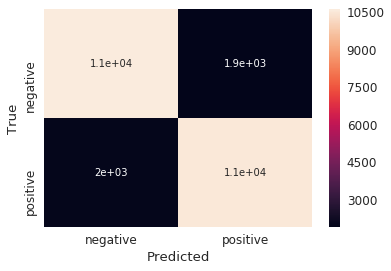

In [24]:
def get_predictions(estimator, input_fn):
    return [x["class_ids"][0] for x in estimator.predict(input_fn=input_fn)]

LABELS = [
    "negative", "positive"
]

# Create a confusion matrix on training data.
with tf.Graph().as_default():
    conf_matrix = tf.confusion_matrix(train_df["polarity"], 
                                      get_predictions(estimator, predict_train_input_fn))
    with tf.Session() as session:
        conf_matrix_out = session.run(conf_matrix)

# Normalize the confusion matrix so that each row sums to 1.
conf_matix_out = conf_matrix_out.astype(float) / conf_matrix_out.sum(axis=1)[:, np.newaxis]

sns.heatmap(conf_matrix_out, annot=True, xticklabels=LABELS, yticklabels=LABELS)
plt.xlabel("Predicted")
plt.ylabel("True")

# Advanced NLP Stuff: Transfer Learning Analysis
***

Transfer learning makes it possible to save training resources and to achieve good model generalization even when training on a small dataset. In this part, we will demonstrate this by training with two different TF-Hub modules:
1. **[nnlm-en-dim128]()** - pretrained text embedding module,
2. **[random-nnlm-en-dim128]()** - text embedding module that has same vocabulary and network as nnlm-en-dim128, but the weights were just randomly initialized and never trained on real data.

And by training in two modes:
1. training **<font color=blue>only the classifier</font>** (i.e. freezing the module), and
2. training the **<font color=blue>classifier together with the module</font>.**


### A bit about Transfer Learning (courtesy Stanford Course)
***

#### Transfer Learning

In practice, very few people train an entire Convolutional Network from scratch (with random initialization), because it is relatively rare to have a dataset of sufficient size. Instead, it is common to pretrain a ConvNet on a very large dataset (e.g. ImageNet, which contains 1.2 million images with 1000 categories), and then use the ConvNet either as an initialization or a fixed feature extractor for the task of interest. The three major Transfer Learning scenarios look as follows:

1. **ConvNet as fixed feature extractor.** Take a ConvNet pretrained on ImageNet, remove the last fully-connected layer (this layer’s outputs are the 1000 class scores for a different task like ImageNet), then treat the rest of the ConvNet as a fixed feature extractor for the new dataset. In an AlexNet, this would compute a 4096-D vector for every image that contains the activations of the hidden layer immediately before the classifier. We call these features CNN codes. It is important for performance that these codes are ReLUd (i.e. thresholded at zero) if they were also thresholded during the training of the ConvNet on ImageNet (as is usually the case). Once you extract the 4096-D codes for all images, train a linear classifier (e.g. Linear SVM or Softmax classifier) for the new dataset.
2. **Fine-tuning the ConvNet.** The second strategy is to not only replace and retrain the classifier on top of the ConvNet on the new dataset, but to also fine-tune the weights of the pretrained network by continuing the backpropagation. It is possible to fine-tune all the layers of the ConvNet, or it’s possible to keep some of the earlier layers fixed (due to overfitting concerns) and only fine-tune some higher-level portion of the network. This is motivated by the observation that the earlier features of a ConvNet contain more generic features (e.g. edge detectors or color blob detectors) that should be useful to many tasks, but later layers of the ConvNet becomes progressively more specific to the details of the classes contained in the original dataset. In case of ImageNet for example, which contains many dog breeds, a significant portion of the representational power of the ConvNet may be devoted to features that are specific to differentiating between dog breeds.
3. **Pretrained models.** Since modern ConvNets take 2-3 weeks to train across multiple GPUs on ImageNet, it is common to see people release their final ConvNet checkpoints for the benefit of others who can use the networks for fine-tuning. For example, the Caffe library has a Model Zoo where people share their network weights.

##### When and how to fine-tune?

How do you decide what type of transfer learning you should perform on a new dataset? This is a function of several factors, but the two most important ones are the size of the new dataset (small or big), and its similarity to the original dataset (e.g. ImageNet-like in terms of the content of images and the classes, or very different, such as microscope images). Keeping in mind that ConvNet features are more generic in early layers and more original-dataset-specific in later layers, here are some common rules of thumb for navigating the 4 major scenarios:

1. New dataset is small and similar to original dataset. Since the data is small, it is not a good idea to fine-tune the ConvNet due to overfitting concerns. Since the data is similar to the original data, we expect higher-level features in the ConvNet to be relevant to this dataset as well. Hence, the best idea might be to train a linear classifier on the CNN codes.
2. New dataset is large and similar to the original dataset. Since we have more data, we can have more confidence that we won’t overfit if we were to try to fine-tune through the full network.
3. New dataset is small but very different from the original dataset. Since the data is small, it is likely best to only train a linear classifier. Since the dataset is very different, it might not be best to train the classifier form the top of the network, which contains more dataset-specific features. Instead, it might work better to train the SVM classifier from activations somewhere earlier in the network.
4. New dataset is large and very different from the original dataset. Since the dataset is very large, we may expect that we can afford to train a ConvNet from scratch. However, in practice it is very often still beneficial to initialize with weights from a pretrained model. In this case, we would have enough data and confidence to fine-tune through the entire network.

Some Practical advice. There are a few additional things to keep in mind when performing Transfer Learning:

1. **Constraints from pretrained models.** Note that if you wish to use a pretrained network, you may be slightly constrained in terms of the architecture you can use for your new dataset. For example, you can’t arbitrarily take out Conv layers from the pretrained network. However, some changes are straight-forward: Due to parameter sharing, you can easily run a pretrained network on images of different spatial size. This is clearly evident in the case of Conv/Pool layers because their forward function is independent of the input volume spatial size (as long as the strides “fit”). In case of FC layers, this still holds true because FC layers can be converted to a Convolutional Layer: For example, in an AlexNet, the final pooling volume before the first FC layer is of size [6x6x512]. Therefore, the FC layer looking at this volume is equivalent to having a Convolutional Layer that has receptive field size 6x6, and is applied with padding of 0.
2. **Learning rates.** It’s common to use a smaller learning rate for ConvNet weights that are being fine-tuned, in comparison to the (randomly-initialized) weights for the new linear classifier that computes the class scores of your new dataset. This is because we expect that the ConvNet weights are relatively good, so we don’t wish to distort them too quickly and too much (especially while the new Linear Classifier above them is being trained from random initialization).


OK, lets try some more trainings and evaluations and see how we can use various modules to improve the accuracy and hopefully not overfit as dramatically as above (when we tried just blatantly increasing the number of steps):

In [27]:
def train_and_evaluate_with_module(hub_module, train_module=False):
    embedded_text_feature_column = hub.text_embedding_column(
        key="sentence", module_spec=hub_module, trainable=train_module)
    
    estimator = tf.estimator.DNNClassifier(
        hidden_units=[500, 100],
        feature_columns=[embedded_text_feature_column],
        n_classes=2,
        optimizer=tf.train.AdagradOptimizer(learning_rate=0.003))
    
    estimator.train(input_fn=train_input_fn, steps=1000)
    train_eval_result = estimator.evaluate(input_fn=predict_train_input_fn)
    test_eval_result = estimator.evaluate(input_fn=predict_test_input_fn)
    
    training_set_accuracy = train_eval_result["accuracy"]
    test_set_accuracy = test_eval_result["accuracy"]
    
    return {
      "Training accuracy": training_set_accuracy,
      "Test accuracy": test_set_accuracy
  }


results = {}
results["nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1")
results["nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/nnlm-en-dim128/1", True)
results["random-nnlm-en-dim128"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1")
results["random-nnlm-en-dim128-with-module-training"] = train_and_evaluate_with_module(
    "https://tfhub.dev/google/random-nnlm-en-dim128/1", True)

In [28]:
# Let's check the results
pd.DataFrame.from_dict(results, orient="index")

,Training accuracy,Test accuracy
nnlm-en-dim128,0.80272,0.79344
nnlm-en-dim128-with-module-training,0.95076,0.87104
random-nnlm-en-dim128,0.71772,0.67156
random-nnlm-en-dim128-with-module-training,0.76564,0.72012


##### Do we like what we see?

We can already see some patterns, such as `nnlm-en-dim128-with-module-training` is doing far better than the `nnlm-en-dim128` and same for random-nnlm as well.
How about we also but first establish the baseline accuracy of the test set - the lower bound that can be achieved by outputting only the label of the most represented class:

In [29]:
estimator.evaluate(input_fn=predict_test_input_fn)["accuracy_baseline"]

0.5

### And so, what we see?

Assigning the most represented class will give us accuracy of 50%. There are a couple of things to notice here:
1. Maybe surprisingly, a **model can still be learned on top of fixed, random embeddings**
. The reason is that even if every word in the dictionary is mapped to a random vector, the estimator can separate the space purely using its fully connected layers.
2. Allowing training of the module with **random embeddings** increases both training and test accuracy as oposed to training just the classifier.
3. Training of the module with **pre-trained embeddings** also increases both accuracies. Note however the overfitting on the training set. As you saw above when we ran about 500 epochs worth of steps (100,000). Training a pre-trained module can be dangerous even with regularization in the sense that the embedding weights no longer represent the language model trained on diverse data, instead they converge to the ideal representation of the new dataset.